In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style('whitegrid')

import matplotlib as mpl

from IPython.display import display

import matplotlib.pylab as pylab

from matplotlib import rc

import torch
from torch.nn.functional import log_softmax
from sklearn.model_selection import KFold
from scipy.optimize import minimize
from matplotlib.lines import Line2D
%matplotlib inline 

# Read logs

In [2]:
path = 'mostfinallogs/'
df = pd.concat([pd.read_csv(path + f) for f in os.listdir(path)], sort=False)
df.model = df.model.apply(lambda x: x.replace('do', ''))
df.metric = df.metric.apply(lambda x: x.replace('nll', 'll'))
df.metric = df.metric.apply(lambda x: x.replace('misclass_auroc', 'misclass-auroc'))
df.model = df.model.apply(lambda x: x.replace('Bayes', ''))
df.method = df.method.apply(lambda x: x.lower())
df.method = df.method.apply(lambda x: x.replace('_', '-'))
df = df.groupby(['dataset', 'model', 'method', 'n_samples', 'metric']).value.agg(['mean', 'std', 'max']).reset_index()
display(df.head(5))
df = df.query('method != "sse-alt"')
df = df.query('method != "csgld-long"')
df = df.query('method != "swag-train"')

,dataset,model,method,n_samples,metric,mean,std,max
0,CIFAR10,PreResNet110,csgld,1,acc,0.938160,0.002027,0.940100
1,CIFAR10,PreResNet110,csgld,1,acc_aac,0.007572,0.000569,0.008432
2,CIFAR10,PreResNet110,csgld,1,brier,0.095431,0.004069,0.101074
3,CIFAR10,PreResNet110,csgld,1,ll,-0.213118,0.009314,-0.202445
4,CIFAR10,PreResNet110,csgld,2,acc,0.938160,0.002801,0.941300


# Build Tables

In [3]:
def dee(de, df):
    """Input: two dataframes n_samples, metric, mean.
       Output: dataframe n_samples, metric, dee."""
    res_all = []
    for metric in set(list(df['metric'])):
        if metric == 'brier' or metric.endswith('ce') or metric == 'acc_aac':
            # Decreasing
            isbetter = lambda a, b: a < b
        else:
            # Increasing
            isbetter = lambda a, b: a > b
        de_metric = de.query('metric == "%s"' % metric)
        df_metric = df.query('metric == "%s"' % metric)
        de_iter = iter(de_metric.values)
        try:
            de_n_samples, _, de_mean = next(de_iter)
            de_n_samples_prev, de_mean_prev = de_n_samples, de_mean
        except StopIteration:
            continue
        for n_samples, _, df_mean in df_metric.values:
            while isbetter(df_mean, de_mean):
                de_n_samples_prev, de_mean_prev = de_n_samples, de_mean
                try:
                    de_n_samples, _, de_mean = next(de_iter)
                except StopIteration:
                    break
            
            if de_n_samples == de_n_samples_prev:
                curr_dee = de_n_samples
            else:
                curr_dee = max(de_n_samples_prev, de_n_samples + (df_mean - de_mean) / (de_mean - de_mean_prev))
            res_all.append((n_samples, metric, curr_dee))
    return pd.DataFrame(res_all, columns=['n_samples', 'metric', 'dee'])

query = "dataset=='%s' and model=='%s' and method=='%s'"
columns = ['n_samples', 'metric', 'mean']

for augment in [True, False]:
    all_dee = []
    for dataset in set(df['dataset']):
        for model in set(df['model']):
            for method in set(df['method']):
                if not method.endswith('(ts)'):
                    continue

                df_method = df.query(query % (dataset, model, method))[columns]
                de_query = query % (dataset, model, 'deepens-augment (ts)' if augment else 'deepens (ts)')
                df_de = df.query(de_query)[columns + ['std']].reset_index(drop=True)
                df_de['lower'] = df_de['mean'] + df_de['std']
                df_de['upper'] = df_de['mean'] - df_de['std']

                method_dee = dee(df_de[['n_samples', 'metric', 'mean']], df_method)
                method_dee['upper'] = dee(df_de[['n_samples', 'metric', 'upper']], df_method).dee
                method_dee['lower'] = dee(df_de[['n_samples', 'metric', 'lower']], df_method).dee
                method_dee['dataset'] = dataset
                method_dee['model'] = model
                method_dee['method'] = method
                
                all_dee.append(method_dee)
    
    df_dee = pd.concat(all_dee).reset_index(drop=True).astype({'n_samples': 'int32',
                                                               'dee': 'float64',
                                                               'lower': 'float64',
                                                               'upper': 'float64'})
    if augment:
        df_dee_aug = df_dee
    else:
        df_dee_noda = df_dee

In [4]:
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'x-large',
         'figure.figsize': (6, 4),
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

colors = {
    'deepens': '#1f77b4', 
    'dropout': '#ff7f0e',
    'kfaclaplace': '#2ca02c',
    'onenet': '#d62728',
    'vi': '#9467bd',
    'csgld':'#8c564b',
    'sse':'#e377c2',
    'swag': '#7f7f7f', 
    'fge': '#bcbd22', 
    'stochbn': '#111111',
    'deepens-augment': '#1f77b4', 
    'dropout-augment': '#ff7f0e',
    'kfaclaplace-augment': '#2ca02c',
    'augment': '#d62728',
    'onenet-augment': '#d62728',
    'vi-augment': '#9467bd',
    'csgld-augment':'#8c564b',
    'sse-augment':'#e377c2',
    'swag-augment': '#7f7f7f', 
    'fge-augment': '#bcbd22', 
    'stochbn-augment': '#111111'}
names = {
    'deepens': 'Deep ensemble', 
    'dropout': 'Dropout',
    'kfaclaplace': 'K-FAC Laplace',
    'onenet': 'Single model',
    'vi': 'FFG VI',
    'csgld':'cSGLD',
    'sse':'SSE',
    'swag': 'SWAG', 
    'fge': 'FGE',
    'stochbn': 'Stoch BN',
    'augment': 'Single model + aug',
    'deepens-augment': 'Deep ensemble + aug',
    'dropout-augment': 'Dropout + aug',
    'kfaclaplace-augment': 'K-FAC Laplace + aug',
    'onenet-augment': 'Single model + aug',
    'vi-augment': 'FFG VI + aug',
    'csgld-augment':'cSGLD + aug',
    'sse-augment':'SSE + aug',
    'swag-augment': 'SWAG + aug', 
    'fge-augment': 'FGE + aug',
    'stochbn-augment': 'Stoch BN + aug'}
metric_names = {
    'll': '',
    'brier': 'Brier',
    'acc': 'Accuracy',
    'acc_aac': 'AU-ARC'
}

In [5]:
# df_dee = df_dee_aug
df_dee = df_dee_noda

/home/dmolchanov/anaconda3/envs/megabayes/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in true_divide
/home/dmolchanov/anaconda3/envs/megabayes/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in true_divide
/home/dmolchanov/anaconda3/envs/megabayes/lib/python3.6/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide
/home/dmolchanov/anaconda3/envs/megabayes/lib/python3.6/site-packages/ipykernel_launcher.py:86: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


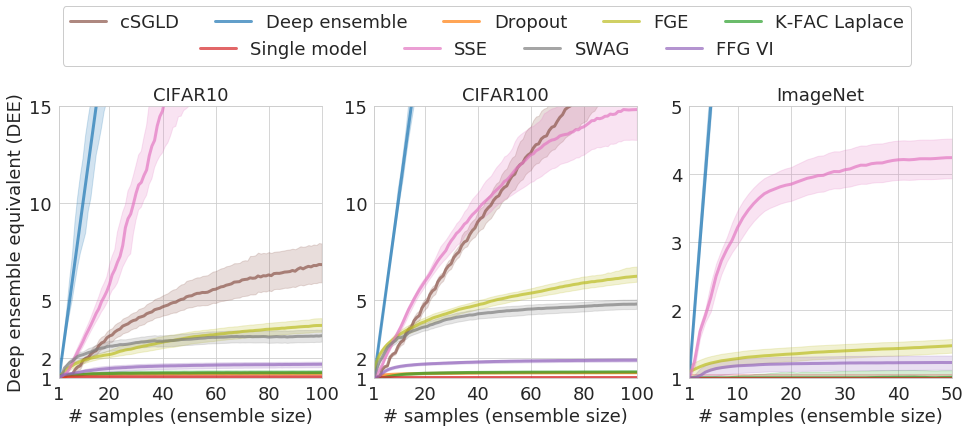

In [6]:
base = 18
params = {'legend.fontsize': base,
         'axes.labelsize': base,
         'figure.figsize': (13, 4),
         'axes.titlesize':base,
         'xtick.labelsize':base,
         'ytick.labelsize':base}
pylab.rcParams.update(params)

augment = False
# for metrics in [['ll'], ['brier'], ['acc'], ['acc_aac']]:
for metrics in [['ll']]:
    i = 1
    f = plt.figure(figsize=(16, 5))
    lines = []
    for datasets in [['CIFAR10'], ['CIFAR100'], ['ImageNet']]:
        models = ['VGG16BN', 'PreResNet110', 'PreResNet164', 'WideResNet28x10', 'ResNet50']

        plt.subplot(1, 3, i)
        i += 1

        j = 0
        for method in sorted(set(df_dee.method.values)):
            if augment != ('aug' in method):
                continue
            if 'stochbn' in method:
                continue
            if 'stoc' in method:
                continue
            n_samples = np.arange(1, 101)
            lower = np.zeros(100)
            upper = np.zeros(100)
            dee = np.zeros(100)
            num_aver = np.zeros(100)
            for model in models:
                for data in datasets:
                    if model == 'ResNet50' and data != 'ImageNet':
                        continue
                    if model != 'ResNet50' and data == 'ImageNet':
                        continue
                    for metric in metrics:
                        q = 'dataset == "%s" and model == "%s" and method == "%s" and metric == "%s" and n_samples <= 100'
                        df_ = df_dee.query(q % (data, model, method, metric))
                        curr_len = len(df_['lower'].values)
                        lower[:curr_len] += df_['lower'].values
                        upper[:curr_len] += df_['upper'].values
                        dee[:curr_len] += df_['dee'].values
                        num_aver[:curr_len] += 1

            c = colors[method.split()[0]]
            m = names[method.split()[0]]

            plt.fill_between(n_samples,
                            lower / num_aver,
                            upper / num_aver,color=c, alpha=0.2)
            line = plt.plot(
                       n_samples, 
                       dee / num_aver,
                       label=m, alpha=0.7, linewidth=3, c=c, linestyle='--' if 'aug' in method else '-')[0]
            if m not in [l.get_label() for l in lines]:
                lines.append(line)
        plt.ylim(1, 15)
        plt.xlim(1, 100)
        plt.xticks([1, 20, 40, 60, 80, 100])
        plt.yticks([1, 2, 5, 10, 15])
#         plt.yticks([1, 10, 20, 30, 40, 50])
        if data == 'ImageNet':
            plt.ylim(1, 5)
            plt.xlim(1, 50)
            plt.xticks([1, 10, 20, 30, 40, 50])
            plt.yticks([1, 2, 3, 4, 5])
        if i == 2:
            plt.ylabel(metric_names[metrics[0]]+'Deep ensemble equivalent (DEE)')#, fontsize=6)
        else:
            pass
        plt.xlabel('# samples (ensemble size)')
        plt.title(datasets[0])

    kw = dict(framealpha=1, bbox_to_anchor=(-0.77, 1.40))
    leg1 = plt.legend(handles=lines[:5], labels=[l.get_label() for l in lines[:5]], ncol=5, loc="upper center", **kw)
    plt.gca().add_artist(leg1)
    leg2 = plt.legend(handles=lines[5:], ncol=4)
    leg2.remove()
    leg1._legend_box._children.append(leg2._legend_handle_box)
    leg1._legend_box.stale = True
    plt.tight_layout(w_pad=2)
    plt.savefig('./dee-average.pdf', bbox_inches='tight')

/home/dmolchanov/anaconda3/envs/megabayes/lib/python3.6/site-packages/ipykernel_launcher.py:52: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
/home/dmolchanov/anaconda3/envs/megabayes/lib/python3.6/site-packages/ipykernel_launcher.py:52: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


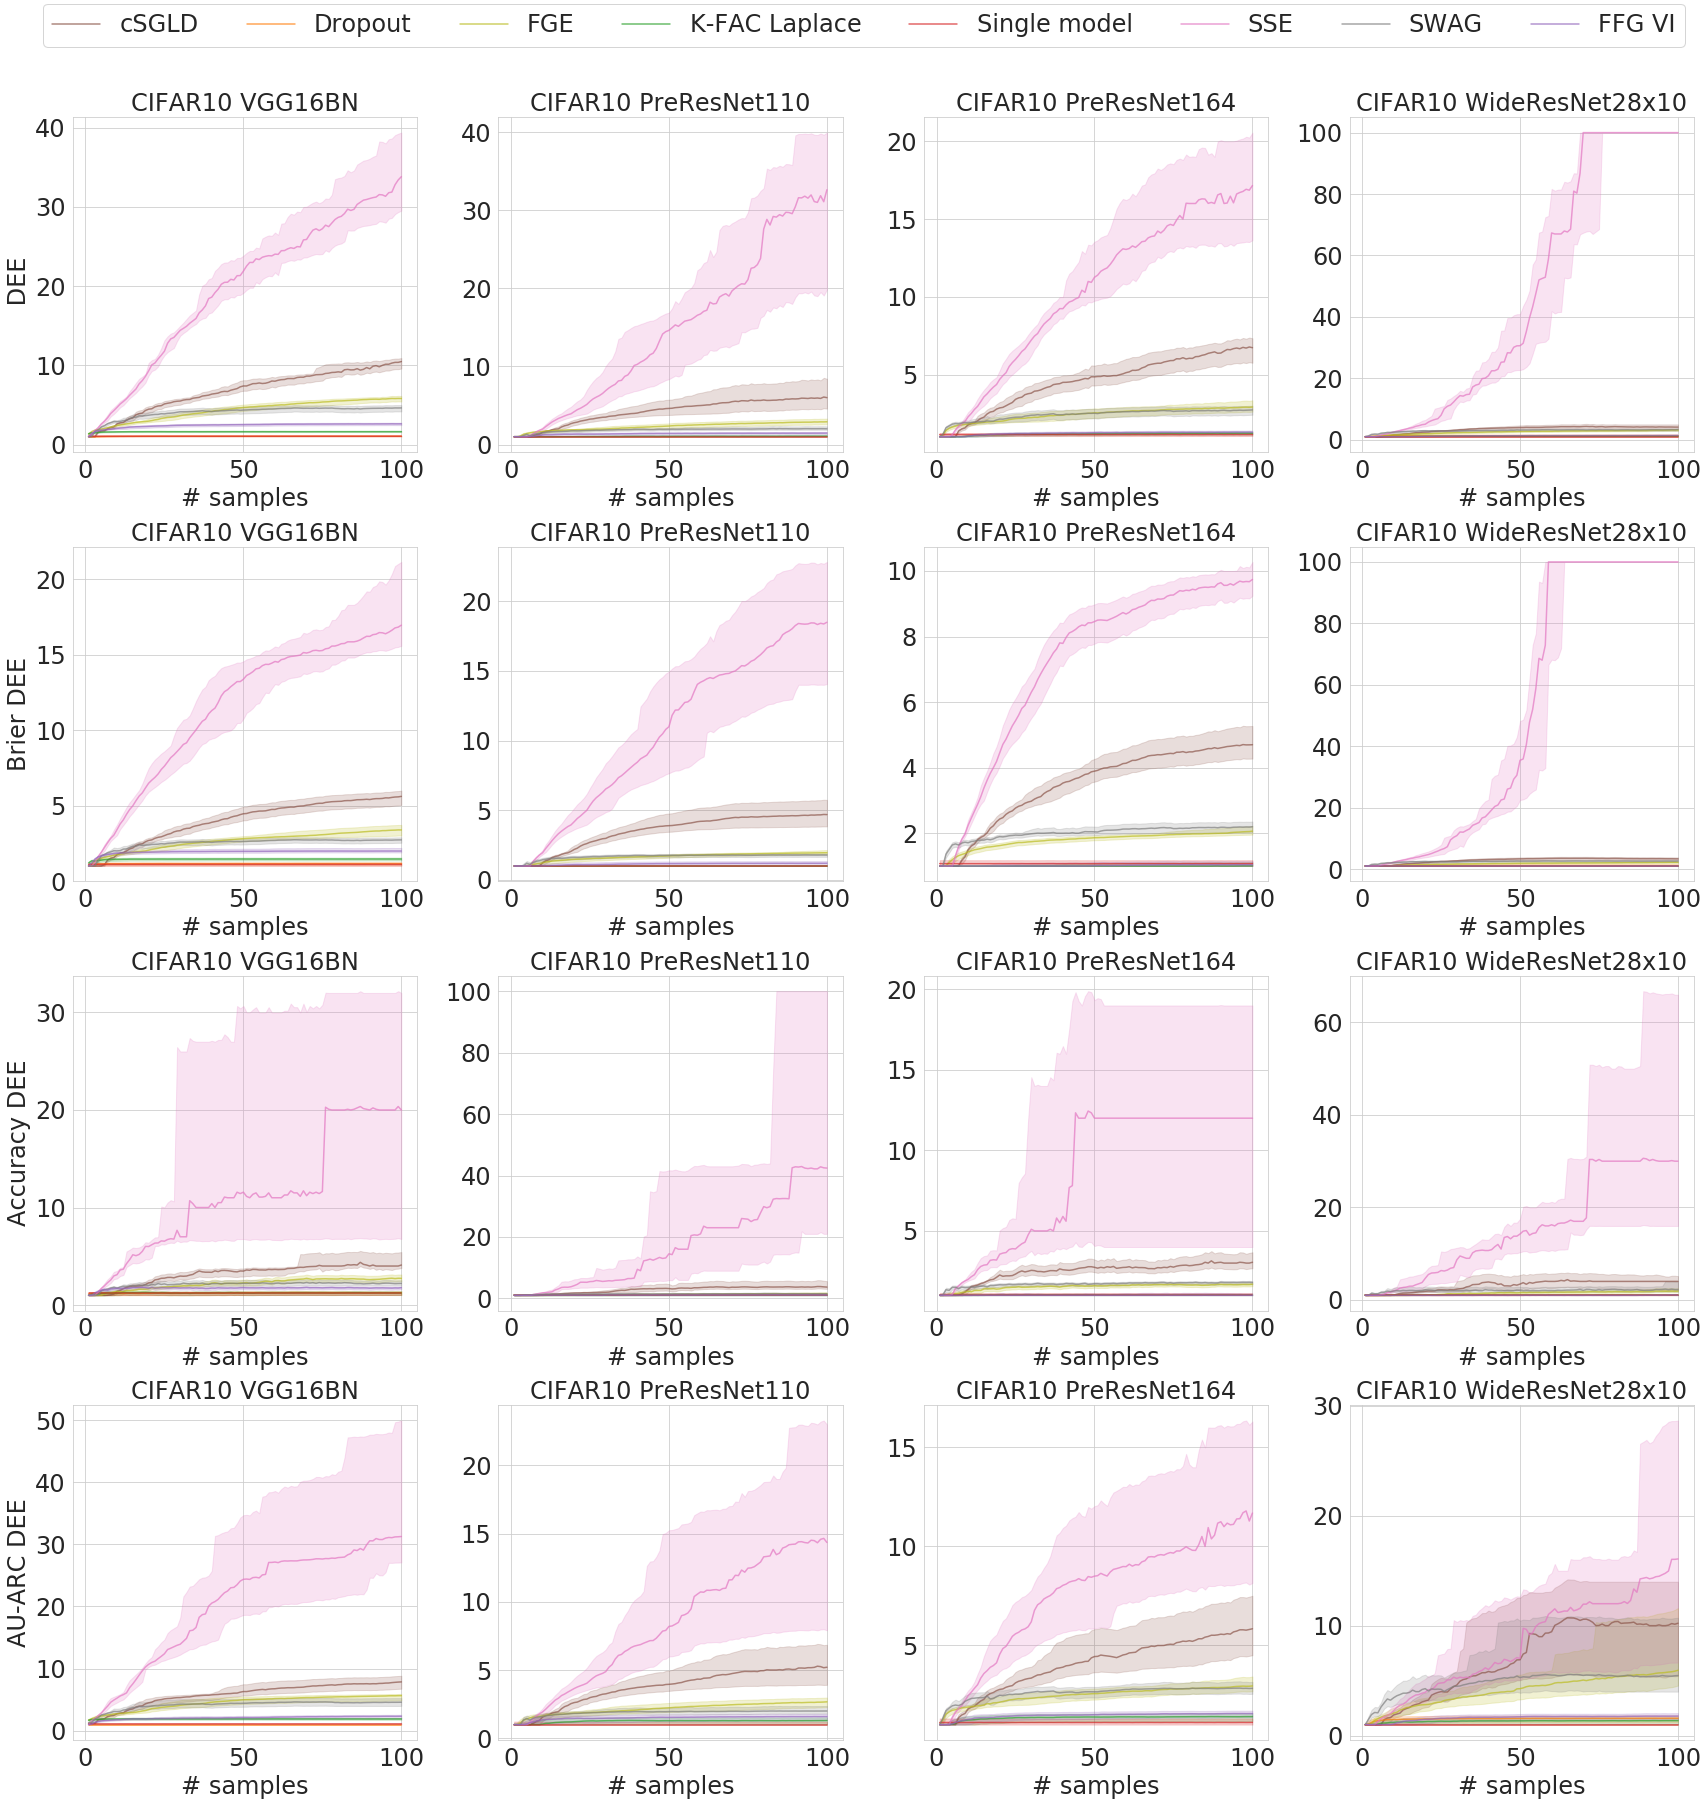

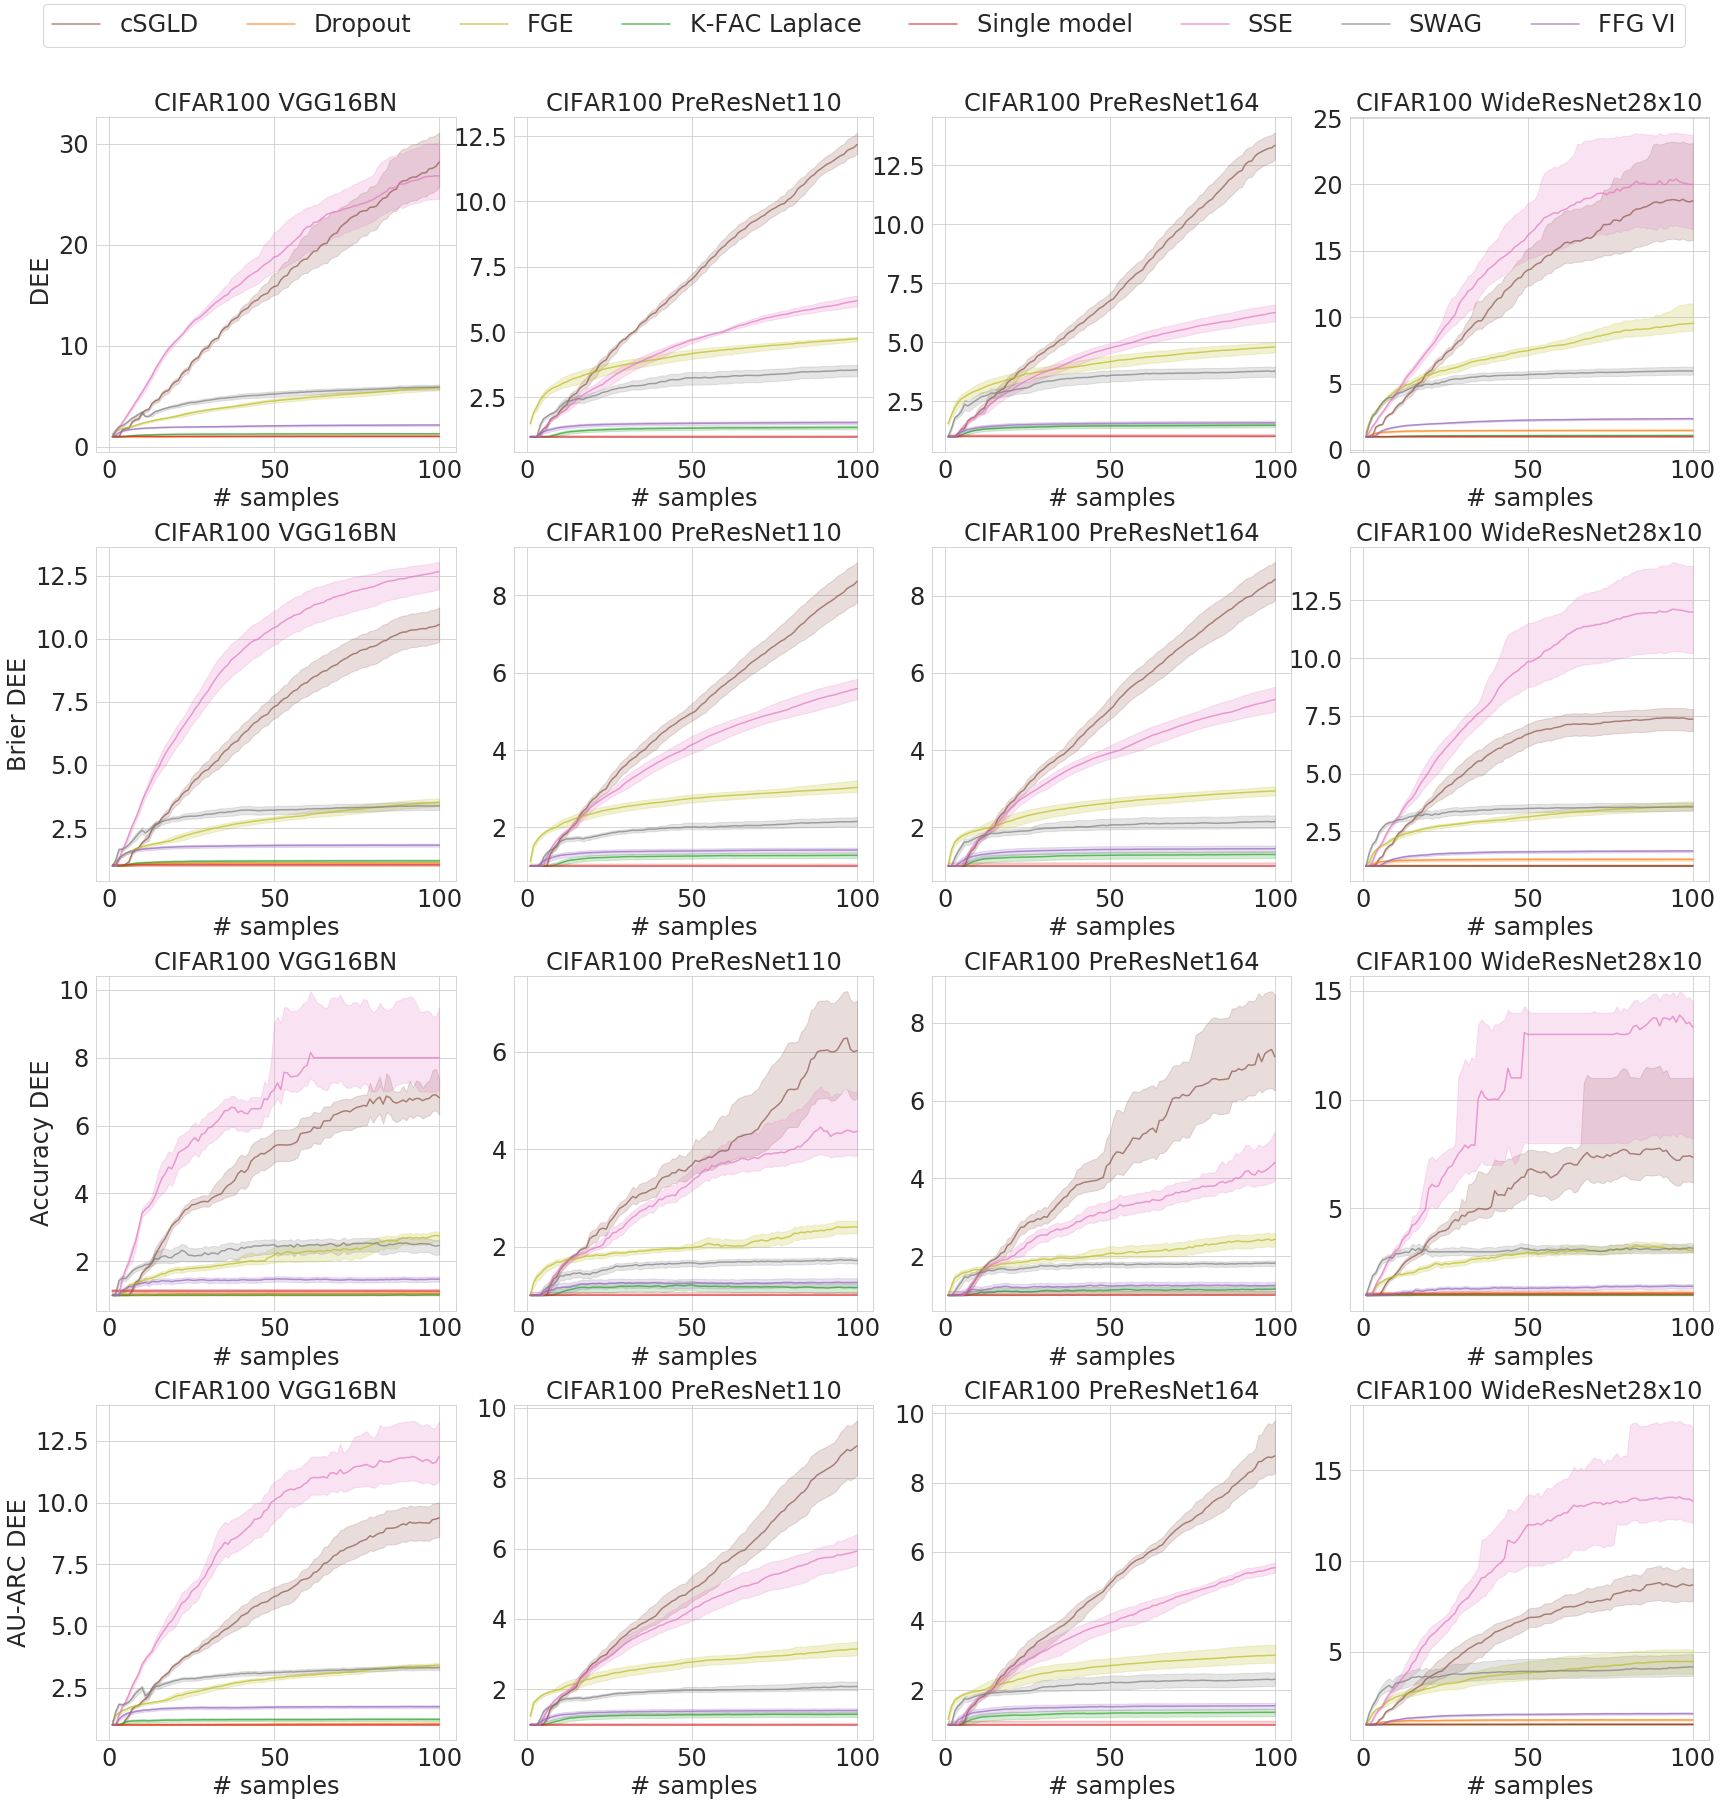

In [7]:
params = {'legend.fontsize': 24,
         'axes.labelsize': 24,
         'figure.figsize': (6, 4),
         'axes.titlesize':24,
         'xtick.labelsize':24,
         'ytick.labelsize':24}
pylab.rcParams.update(params)
for datasets in [['CIFAR10'], ['CIFAR100']]:
    models = ['VGG16BN', 'PreResNet110', 'PreResNet164', 'WideResNet28x10']
    mpl.rcParams['figure.figsize'] = 24, 24
    di = 0
    f=plt.figure()
    i = 1
    for metrics in [['ll'], ['brier'], ['acc'], ['acc_aac']]:
        j = 0
        for model in models:
            for data in datasets:
                for metric in metrics:
                    plt.subplot(4, 4, i)
                    i += 1
                    lines = []
                    for method in sorted(set(df_dee.method.values)):
                        if 'aug' in method:
                            continue
                        if 'stochbn' in method:
                            continue
                        if method.startswith('deepens'):
                            continue
                        q = 'dataset == "%s" and model == "%s" and method == "%s" and metric == "%s" and n_samples <= 100'
                        df_ = df_dee.query(q % (data, model, method, metric))
                        if len(df_dee.query('dataset == "%s" and model == "%s" and method == "%s"' % (data, model, method))) > 0:
                            if method.split()[0] in colors:
                                c = colors[method.split()[0]]
                                m = names[method.split()[0]]
                            else:
                                print(method.split()[0])
                                raise NotImplementedError
                                colors[method.split()[0]] = current_palette.as_hex()[j % len(current_palette.as_hex())]
                                j += 1
                                c = colors[method.split()[0]]
                            plt.fill_between(df_['n_samples'].values,
                                            df_['lower'].values,
                                            df_['upper'].values,color=c, alpha=0.2)
                            lines.append(plt.plot(
                                df_['n_samples'].values, 
                                df_['dee'].values, 
                                label=m, alpha=0.7, c=c, linestyle='--' if 'aug' in method else '-')[0])
                    if i % 4 == 2:
                        plt.ylabel(metric_names[metrics[0]]+' DEE')
                    plt.xlabel('# samples')
                    plt.title('%s %s' % (data, model))
    f.legend(lines, labels=[l.get_label() for l in lines], ncol=8, loc='upper center', prop={'size': 24}, bbox_to_anchor=(0.5, 1.05))
    plt.tight_layout()
    di += 1
    plt.savefig('./dee-verbose-%s.pdf' % (data), bbox_inches='tight')

/home/dmolchanov/anaconda3/envs/megabayes/lib/python3.6/site-packages/ipykernel_launcher.py:54: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


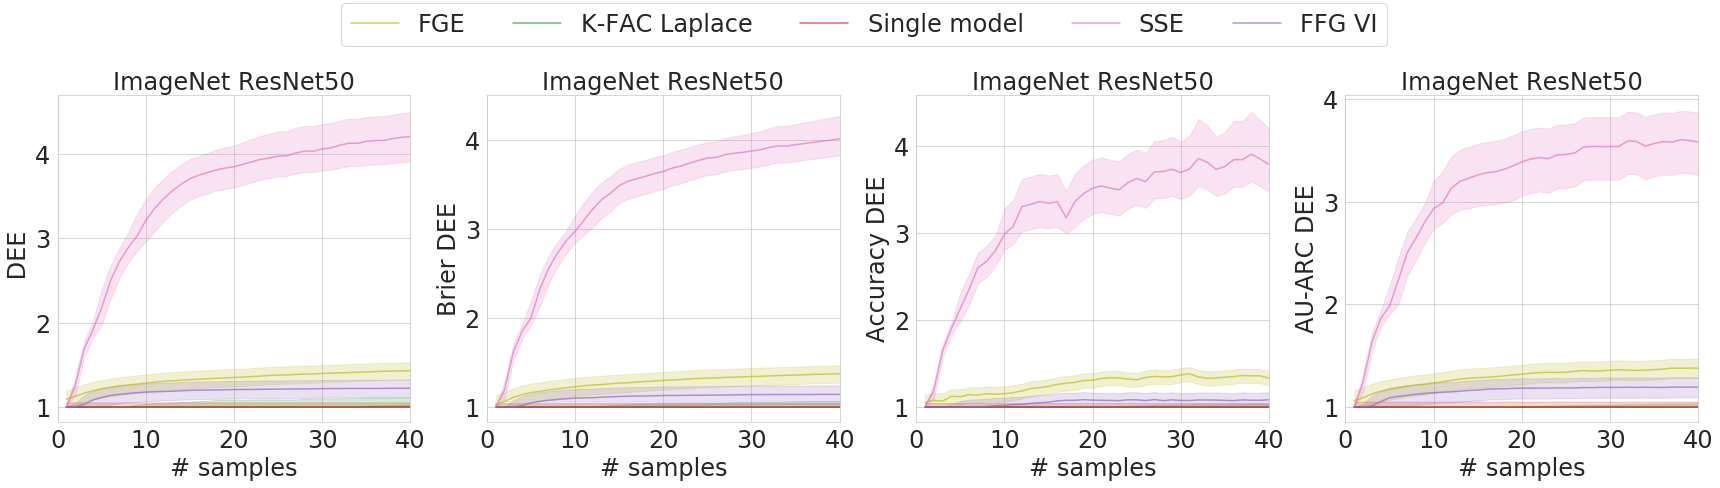

In [8]:
params = {'legend.fontsize': 24,
         'axes.labelsize': 24,
         'figure.figsize': (6, 4),
         'axes.titlesize':24,
         'xtick.labelsize':24,
         'ytick.labelsize':24}
pylab.rcParams.update(params)
for datasets in [['ImageNet']]:
    models = ['ResNet50']
    mpl.rcParams['figure.figsize'] = 24, 6
    di = 0
    f=plt.figure()
    i = 1
    for metrics in [['ll'], ['brier'], ['acc'], ['acc_aac']]:
        # colors = {}
        j = 0
        for model in models:
            for data in datasets:
                for metric in metrics:
                    plt.subplot(1, 4, i)
                    i += 1
                    lines = []
                    for method in sorted(set(df_dee.method.values)):
                        if 'aug' in method:
                            continue
                        if 'stochbn' in method:
                            continue
                        if method.startswith('deepens'):
                            continue
                        q = 'dataset == "%s" and model == "%s" and method == "%s" and metric == "%s" and n_samples <= 100'
                        df_ = df_dee.query(q % (data, model, method, metric))
                        if len(df_dee.query('dataset == "%s" and model == "%s" and method == "%s"' % (data, model, method))) > 0:
                            if method.split()[0] in colors:
                                c = colors[method.split()[0]]
                                m = names[method.split()[0]]
                            else:
                                print(method.split()[0])
                                raise NotImplementedError
                                colors[method.split()[0]] = current_palette.as_hex()[j % len(current_palette.as_hex())]
                                j += 1
                                c = colors[method.split()[0]]
                            plt.fill_between(df_['n_samples'].values,
                                            df_['lower'].values,
                                            df_['upper'].values,color=c, alpha=0.2)
                            lines.append(plt.plot(
                                df_['n_samples'].values, 
                                df_['dee'].values, 
                                label=m, alpha=0.7, c=c, linestyle='--' if 'aug' in method else '-')[0])

                    plt.xlim(0, 40)
                    plt.ylabel(metric_names[metrics[0]]+' DEE')
                    plt.xlabel('# samples')
                    plt.title('%s %s' % (data, model))
    f.legend(lines, labels=[l.get_label() for l in lines], ncol=8, loc='upper center', prop={'size': 24}, bbox_to_anchor=(0.5, 1.15))
    plt.tight_layout()
    di += 1
    plt.savefig('./dee-verbose-%s.pdf' % (data), bbox_inches='tight')